In [1]:
# importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data

df = pd.read_csv("listings_eda")
df.head()

,borough,neighbourhood,room_type_labeled,price,reviews_count,bathrooms,bedrooms,price_range_labeled
0,Brooklyn,Sunset Park,0,275,1,1.0,2.0,2
1,Manhattan,Upper West Side,1,75,0,1.0,1.0,0
2,Brooklyn,Bedford-Stuyvesant,1,60,0,1.0,1.0,1
3,Manhattan,Midtown,1,68,50,1.0,1.0,1
4,Manhattan,East Harlem,1,65,1,1.0,1.0,1


In [3]:
len(df.neighbourhood.unique())

222

There are 222 unique values for `neighbourhood`. I will try frequency encoding which involves encoding each category with its frequency in the dataset.

In [4]:
# creating a dictionary to store frequencies of each category
freq_dict = df.neighbourhood.value_counts(normalize=True).to_dict()

#replacing each category in the column with its corresponding frequency
df['neighbourhood_freq'] = df['neighbourhood'].map(freq_dict)

A neighbourhood with fewer listings will have a smaller value. This can indicate that the neighbourhood is less desireable, but it can also mean it might not be as highly populated or have a smaller area. 

To account for this, I will target encode the column, by using the price (dependent variable) to capture the relationship between the feature and the target. Each category will be encoded using the mean rental price of that category.

In [5]:
#creating a new column to hold the target encoded values
df['neighbourhood_target_encoded'] = np.nan

#looping through each neighbourhood
for neighbourhood in df.neighbourhood.unique():
    #calculate mean price for current neighbourhood
    mean_price = df.loc[df.neighbourhood == neighbourhood, 'price'].mean()
    #replace the neighbourhood with its mean price
    df.loc[df.neighbourhood == neighbourhood, 'neighbourhood_target_encoded'] = mean_price

#we no longer need the original column, I will drop it.
df.drop('neighbourhood', axis=1, inplace=True)

In [6]:
df.head()

,borough,room_type_labeled,price,reviews_count,bathrooms,bedrooms,price_range_labeled,neighbourhood_freq,neighbourhood_target_encoded
0,Brooklyn,0,275,1,1.0,2.0,2,0.007502,128.501779
1,Manhattan,1,75,0,1.0,1.0,0,0.035239,217.709848
2,Brooklyn,1,60,0,1.0,1.0,1,0.075282,142.281915
3,Manhattan,1,68,50,1.0,1.0,1,0.035906,353.383643
4,Manhattan,1,65,1,1.0,1.0,1,0.020556,149.758442


Finally, I will dummy encode the borough column

In [7]:
#creating the dummies and merging them back to the original dataframe
encoded_df = pd.get_dummies(df['borough'], drop_first=True)
df = pd.concat([df, encoded_df], axis=1)

#we can drop the 'borough' column now
df.drop('borough', axis=1, inplace=True)

In [8]:
df.head()

,room_type_labeled,price,reviews_count,bathrooms,bedrooms,price_range_labeled,neighbourhood_freq,neighbourhood_target_encoded,Brooklyn,Manhattan,Queens,Staten Island
0,0,275,1,1.0,2.0,2,0.007502,128.501779,1,0,0,0
1,1,75,0,1.0,1.0,0,0.035239,217.709848,0,1,0,0
2,1,60,0,1.0,1.0,1,0.075282,142.281915,1,0,0,0
3,1,68,50,1.0,1.0,1,0.035906,353.383643,0,1,0,0
4,1,65,1,1.0,1.0,1,0.020556,149.758442,0,1,0,0


In [9]:
y = df.price
X = df.drop(['price'], axis=1)

<AxesSubplot:>

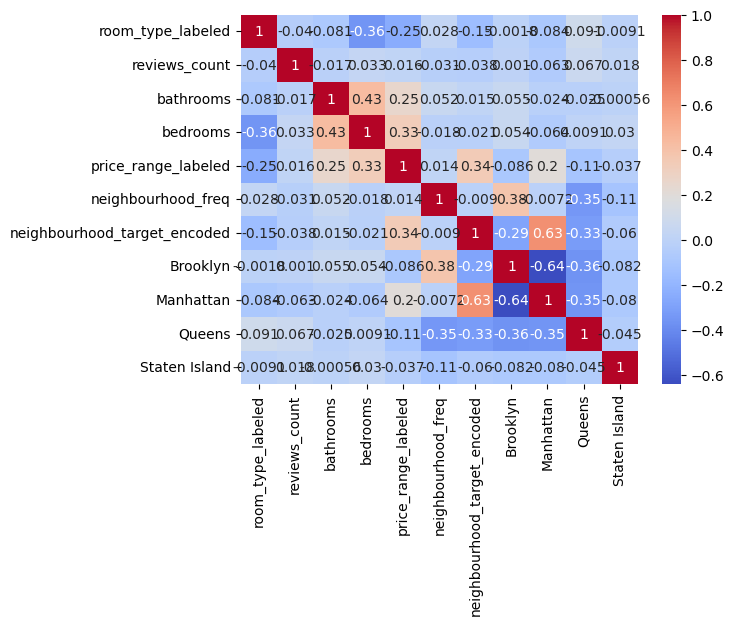

In [10]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')